In [2]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
'''Bring in Dublin bike data'''
data_2018_q3 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data_2018_q4 = pd.read_csv('dublinbikes_20181001_20190101.csv')
data_2018 = pd.concat([data_2018_q3,data_2018_q4],axis=0)

data_2019_q1 = pd.read_csv('dublinbikes_20190101_20190401.csv')
data_2019_q2 = pd.read_csv('dublinbikes_20190401_20190701.csv')
data_2019_q3 = pd.read_csv('dublinbikes_20190701_20191001.csv')
data_2019_q4 = pd.read_csv('dublinbikes_20191001_20200101.csv')
data_2019 = pd.concat([data_2019_q1,data_2019_q2,data_2019_q3,data_2019_q4],axis=0)

data_2020_q1 = pd.read_csv('dublinbikes_20200101_20200401.csv')
data_2020_q2 = pd.read_csv('dublinbikes_20200401_20200701.csv')
data_2020_q3 = pd.read_csv('dublinbikes_20200701_20201001.csv')
data_2020_q4 = pd.read_csv('dublinbikes_20201001_20210101.csv')
data_2020 = pd.concat([data_2020_q1,data_2020_q2,data_2020_q3,data_2020_q4],axis=0)

data_2021_q1 = pd.read_csv('dublinbikes_20210101_20210401.csv')
data_2021_q2 = pd.read_csv('dublinbikes_20210401_20210701.csv')
data_2021_q3 = pd.read_csv('dublinbikes_20210701_20211001.csv')
data_2021_q4 = pd.read_csv('dublinbikes_20211001_20220101.csv')
data_2021 = pd.concat([data_2021_q1,data_2021_q2,data_2021_q3,data_2021_q4],axis=0)


In [4]:
#%%
'''Define function to clean raw data'''
def clean_data(data_to_run):
    '''
    Clean column names and split out times
    '''
    data_to_run=data_to_run[data_to_run['STATUS']== 'Open']
    data_to_run=data_to_run[data_to_run['STATION ID']!=507]
    data_to_run.rename(columns=
            {'STATION ID':'station_id',
                'TIME':'timestamp', 
                'NAME':'name',
                'BIKE STANDS':'no_stands', 
                'AVAILABLE BIKE STANDS':'free_stands', 
                'AVAILABLE BIKES':'free_bikes',
                'LAST UPDATED':'last_updated', 
                'STATUS':'status',
                'ADDRESS':'address',
                'LATITUDE':'latitude',
                'LONGITUDE':'longitude'
                },inplace=True)

    data_to_run.drop_duplicates(keep= 'first',inplace=True)
    data_to_run['proportion_filled'] = (data_to_run['free_bikes']/data_to_run['no_stands'])

    #Change times from strings to datetimes
    data_to_run['timestamp']= pd.to_datetime((data_to_run['timestamp']),format ='%Y-%m-%d %H:%M:%S.%f' )
    #split out individual time attributes 

    data_to_run["date"] = [d.date() for d in data_to_run["timestamp"]]
    data_to_run["time"] = [d.time() for d in data_to_run["timestamp"]]
    data_to_run['year'] = pd.DatetimeIndex(data_to_run['timestamp']).year
    # data_to_run['month'] = pd.DatetimeIndex(data_to_run['timestamp']).month
    data_to_run['hour'] = pd.DatetimeIndex(data_to_run['timestamp']).hour
    data_to_run['time_of_day'] = pd.DatetimeIndex(data_to_run['timestamp']).hour
    # data_to_run['minute'] = pd.DatetimeIndex(data_to_run['timestamp']).minute
    data_to_run['day_num'] = pd.DatetimeIndex(data_to_run['timestamp']).weekday
    data_to_run['day_name'] = pd.DatetimeIndex(data_to_run['timestamp']).weekday
    data_to_run['workday'] = pd.DatetimeIndex(data_to_run['timestamp']).weekday
    data_to_run.drop(['timestamp'], axis = 1)

    #rename some data using dictionaries
    day_str = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
    day_num = (0,1,2,3,4,5,6)
    day_zip = zip(day_num,day_str)
    day_list= list(day_zip)
    day_dict = dict(day_list)

    workday_str = ('midweek','midweek','midweek','midweek','midweek','weekend','weekend')
    workday_zip = zip(day_num,workday_str)
    workday_list= list(workday_zip)
    workday_dict = dict(workday_list)

    hour_str = ('night','night','night','night','night','night','morning','morning','morning','morning','morning','midday','midday','midday','midday','midday','evening','evening','evening','evening','night','night','night','night')
    hour_num = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
    hour_zip = zip(hour_num,hour_str)
    hour_list= list(hour_zip)
    hour_dict = dict(hour_list)

    data_to_run['day_name'].replace(day_dict,inplace=True)
    data_to_run['workday'].replace(workday_dict,inplace=True)
    data_to_run['workday'] = data_to_run['workday'].astype('category')
    data_to_run['time_of_day'].replace(hour_dict,inplace=True)
    data_to_run['time_of_day'] = data_to_run['time_of_day'].astype('category')

    '''Identify days when they recirculate the bikes, I might drop these from the data 
    '''
    # identify bikes coming and going
    data_to_run['bike_change'] = data_to_run.groupby('station_id')['free_stands'].diff(-1)
    data_to_run['bikes_put_in'] = np.where(data_to_run['bike_change'] > 0, data_to_run['bike_change'], 0)
    data_to_run['bikes_taken_out'] = np.where(data_to_run['bike_change'] < 0, data_to_run['bike_change'], 0)
    data_to_run['activity'] = np.where(abs(data_to_run['bike_change']) >= 10, "recirculate", "personal_use")
    data_to_run['too_full/empty'] = np.where(data_to_run['proportion_filled'] < .1, 1, np.where(data_to_run['proportion_filled'] > .9, 1,0 ))

    # Count how many times in the day the bikes were recirculated
    data_to_run['recirculating'] = np.where(data_to_run['activity'] == 'recirculate', 1,0)
    data_to_run['join_on'] = data_to_run['station_id'].apply(str)  + (data_to_run['date']).apply(str) 
    join_table= data_to_run.groupby(['join_on'])['recirculating'].sum()
    data_to_run = data_to_run.drop(['recirculating'], axis = 1)
    join_table = join_table.to_frame()
    join_table =join_table.reset_index()
    data_to_run = pd.merge(data_to_run, join_table, on = 'join_on', how = 'left')
    data_to_run = data_to_run.drop(['join_on'], axis = 1)

    return data_to_run
#%%


In [5]:
'''Define function to clean data for use in Kmeans testing'''
def clean_Kmeans_data(data_to_run):
    '''Run Kmeans clustering'''

    #group data into clusters
    data_to_run['cluster_group'] =  data_to_run['workday'].astype(str) + data_to_run['time_of_day'].astype(str) 
    df_personal_use= data_to_run.loc[(data_to_run['activity']=='personal_use')]
    df_kmeans = df_personal_use[['station_id', 'name', 'latitude', 'longitude', 'workday', 'time_of_day', 'proportion_filled','cluster_group']]
    df_kmeans = df_kmeans.groupby(['station_id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['proportion_filled'].mean()
    df_kmeans = df_kmeans.set_index('station_id')
    #pivot dataframe for clustering
    df_kmeans = df_kmeans.pivot_table(index= ['name', 'station_id','latitude', 'longitude'] , columns=['cluster_group'], values='proportion_filled')
    df_kmeans  = df_kmeans.reset_index()
    df_kmeans  = df_kmeans .set_index('name')
    df_kmeans = df_kmeans.dropna()
    return df_kmeans


In [6]:
#%%
'''Define function to run the Elbow test for Kmeans testing'''
def elbow_test(df_kmeans):
    '''Elbow Method - finding the optimal K '''
    distortions = []
    K = range(2,10)
    X = np.array(df_kmeans.drop(columns=['station_id', 'latitude', 'longitude'], axis=1).astype(float))
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

        
    plt.figure(figsize=(10,7))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    return plt.show()


In [7]:
#%%
'''Define function to run Kmeans testing to find similar clusters'''
def find_clusters(df_clusters,n):
    '''Function to run Kmeans clustering'''
    X = np.array(df_clusters.drop(columns=['station_id', 'latitude', 'longitude'], axis = 1).astype(float))
    KM = KMeans(n_clusters=n) 
    KM.fit(X)
    clusters = KM.predict(X)

    locations = df_clusters
    locations['cluster'] = clusters
    locations = locations.sort_values(['station_id'])
    locations = locations.reset_index()

    return locations


In [8]:
#%%
'''Define function to plot the clusters on a map of Dublin'''
colourdict_3 ={0: 'blue', 1: 'red', 2: 'orange'}
colourdict_4 = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green'}
colourdict_5 = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
def plot_clusters(plot, title,colourdict_):
    
    colordict = colourdict_
    bstreet = (53.35677,-6.26814)
    dublin_map = folium.Map(location = bstreet,
                            zoom_start=12)
    title_html = f'<h3 align="center" style="font-size:20px"><b>{title}</b></h3>'
    dublin_map.get_root().html.add_child(folium.Element(title_html))
    for LATITUDE, LONGITUDE, cluster, name in zip(plot['latitude'],plot['longitude'], plot['cluster'], plot['name']):
        folium.CircleMarker(
            [LATITUDE, LONGITUDE],
            color = 'b',
            radius = 8,
            fill_color=colordict[cluster],
            fill=True,
            fill_opacity=0.9,
            popup=name
            ).add_to(dublin_map)


     
    # Add the title to the map
    return display(dublin_map)

In [9]:
#%%
'''Run function to clean the data'''
data_2018_clean = clean_data(data_2018)
data_2019_clean = clean_data(data_2019)
data_2020_clean = clean_data(data_2020)
data_2021_clean = clean_data(data_2021)

In [ ]:
#%%
'''Manipulate data for Kmeans clustering'''
Kmeans_2018 = clean_Kmeans_data(data_2018_clean)
Kmeans_2019 = clean_Kmeans_data(data_2019_clean)
Kmeans_2020 = clean_Kmeans_data(data_2020_clean)
Kmeans_2021 = clean_Kmeans_data(data_2021_clean)

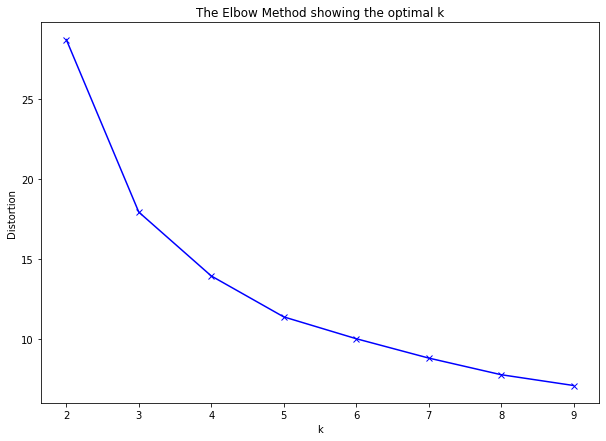

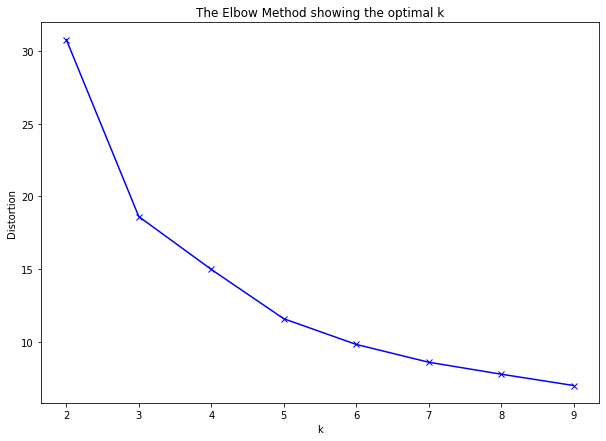

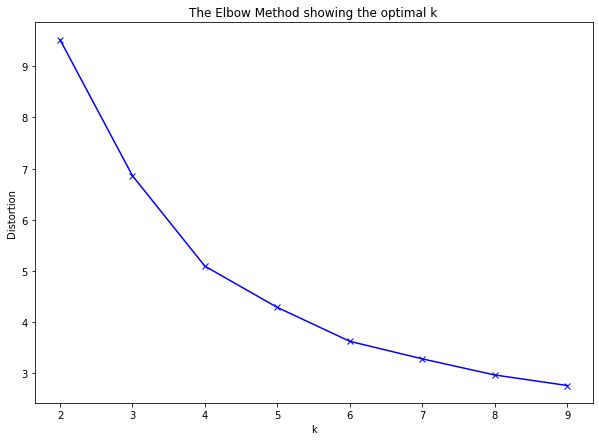

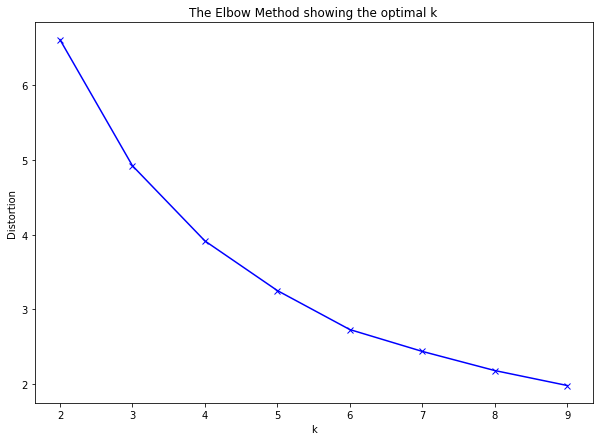

In [ ]:
#%%
'''Run the elbow test for Kmeans clustering'''
elbow_test_2018 = elbow_test(Kmeans_2018,)
elbow_test_2019 = elbow_test(Kmeans_2019)
elbow_test_2020 = elbow_test(Kmeans_2020)
elbow_test_2021 = elbow_test(Kmeans_2021)

In [ ]:
#%%
'''Run Kmeans Clustering'''
clusters_2018 = find_clusters(Kmeans_2018,5)
clusters_2019 = find_clusters(Kmeans_2019,5)
clusters_2020 = find_clusters(Kmeans_2020,5)
clusters_2021 = find_clusters(Kmeans_2021,5)

In [ ]:
#%%
'''Plot clusters on map for each year'''
plots = [clusters_2018,clusters_2019,clusters_2020,clusters_2021]
titles = ['5clusters_2018','5clusters_2019','5clusters_2020','5clusters_2021']
colourdicts = [colourdict_5,colourdict_5,colourdict_5,colourdict_5]
for plot,title,colourdict_ in zip(plots,titles,colourdicts):
    plot_clusters(plot,title,colourdict_)




In [ ]:
#%%
'''Define function to join clusters back into clean data'''
def join_clusters(df_clusters,df_clean):
    '''Join clusters back into clean data'''
    df_clusters[['station_id','cluster']].drop_duplicates()
    df_clusters = df_clusters.sort_values('station_id')
    df_clusters=df_clusters.reset_index()
    df_clusters = df_clusters[['station_id','cluster']]
    df_clean_clusters = df_clean.merge(df_clusters,on='station_id',how='left')
    return df_clean_clusters


    

# %%
'''Join clusters back into clean data'''
data_clean_clusters_2018 = join_clusters(clusters_2018,data_2018_clean)
data_clean_clusters_2019 = join_clusters(clusters_2019,data_2019_clean)
data_clean_clusters_2020 = join_clusters(clusters_2020,data_2020_clean)
data_clean_clusters_2021 = join_clusters(clusters_2021,data_2021_clean)

(0.0, 1.0)

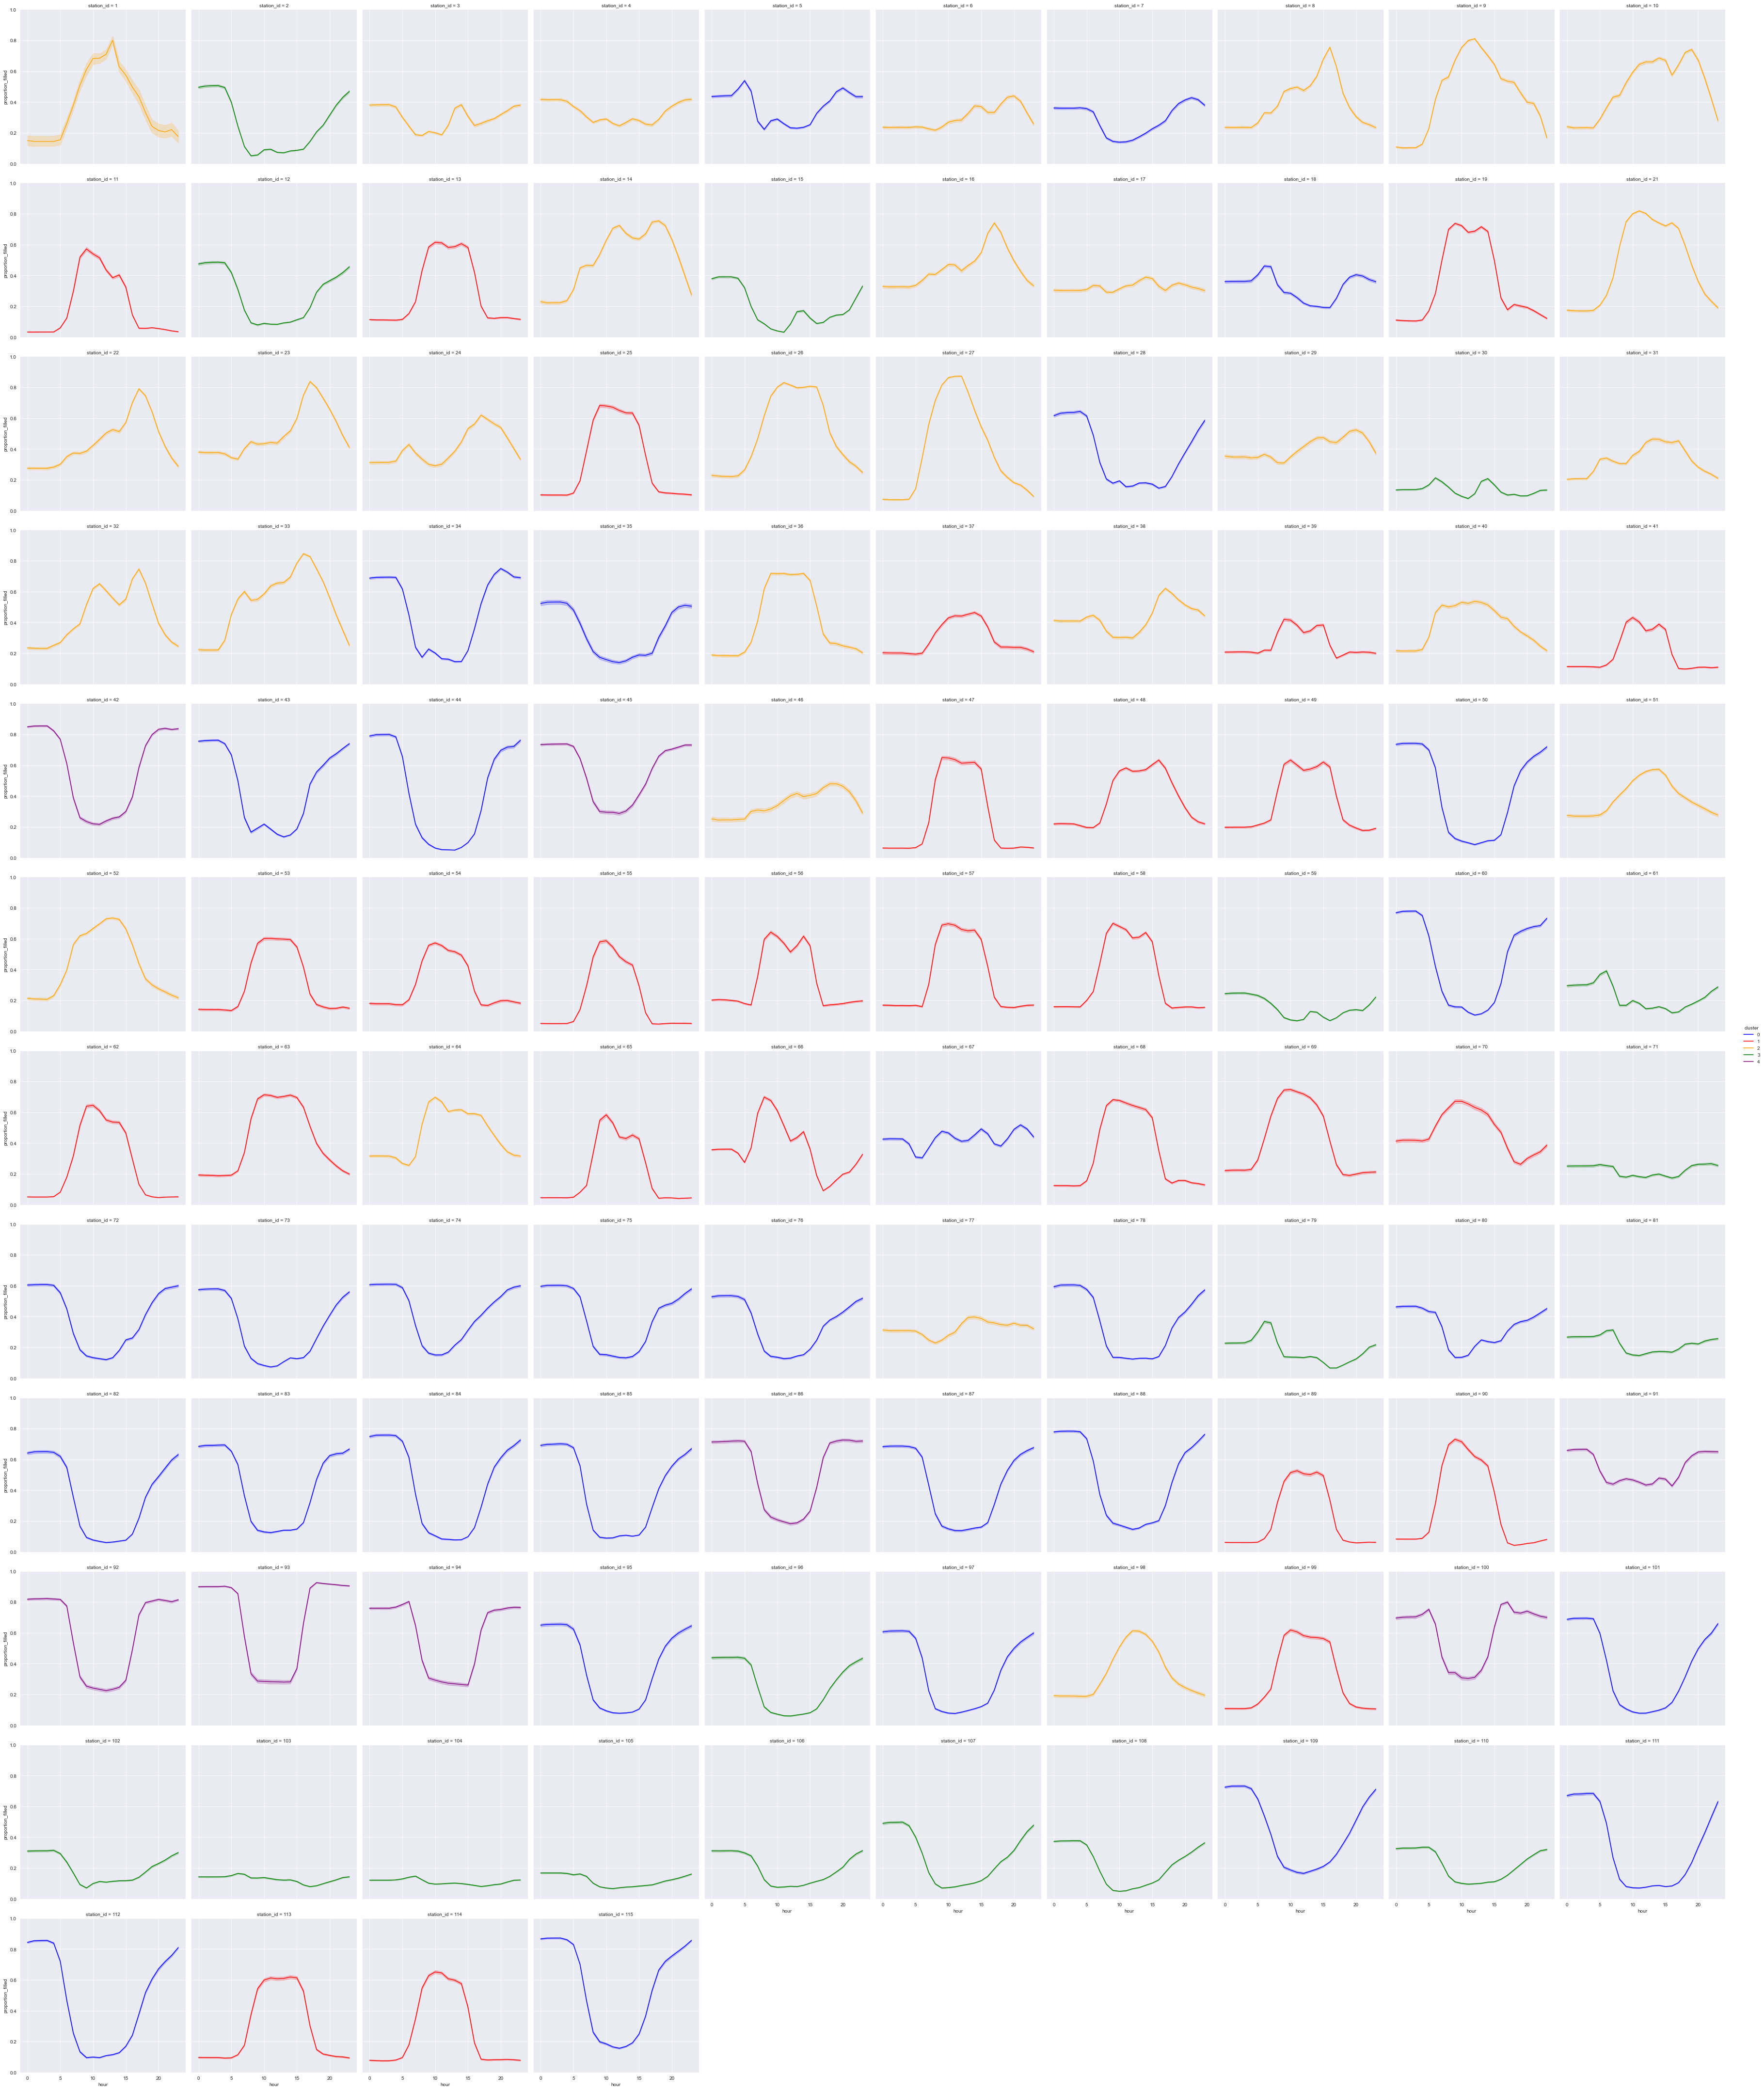

In [7]:
'''
relplot showing % of bikes in a each stand over the course of a day
I'm hoping that U shaped graphs will show origin stations that people leave during the day ie. peoples homes
n shaped graphs should show destination stations that people arrive at in the morning and leave from at night 
plotting the workday as the hue we should see changes in the stations only used for commuting
Would like to compare these against the clusters identified through KMeans.
'''
palette = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
sns.set_style('darkgrid')
sns.relplot(
x='hour',
y='proportion_filled',
kind = 'line',
data=data_clean_clusters_2019,
col='station_id',
col_wrap=10,
hue = 'cluster',
palette = palette
        )
plt.ylim(0,1)